In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,classification_report
from urllib.parse import urlparse
import re
import whois
import datetime
import requests
from wordcloud import WordCloud

In [2]:
# This is main refrences to extract features from URLs
#https://towardsdatascience.com/phishing-domain-detection-with-ml-5be9c99293e5
#https://arxiv.org/pdf/2205.05121.pdf

## Data reading

- reading the CSV

In [3]:
df = pd.read_csv('urldata.csv')
print('Shape of DataFrame:', df.shape)
print('Size of DataFrame:', df.size)
df_copy = df.copy()

Shape of DataFrame: (450176, 4)
Size of DataFrame: 1800704


- checking first five rows

In [4]:
df.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


- checking last five rows

In [5]:
df.tail()


,Unnamed: 0,url,label,result
450171,450171,http://ecct-it.com/docmmmnn/aptgd/index.php,malicious,1
450172,450172,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1
450173,450173,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1
450174,450174,http://atualizapj.com/,malicious,1
450175,450175,http://writeassociate.com/test/Portal/inicio/I...,malicious,1


## concise summary of our dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  450176 non-null  int64 
 1   url         450176 non-null  object
 2   label       450176 non-null  object
 3   result      450176 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 13.7+ MB


## Describing the Data

In [7]:
df.describe(exclude='number').T

,count,unique,top,freq
url,450176,450176,https://www.google.com,1
label,450176,2,benign,345738


## Checking for null values

In [8]:
df.isna().sum()

Unnamed: 0    0
url           0
label         0
result        0
dtype: int64

## Checking if there are duplicates

In [9]:
df.duplicated().sum()

0

## Data Sampling

In [10]:

benign_data = df[df['label']=='benign'].sample(n=2500,random_state=25)
malicious_data = df[df['label']=='malicious'].sample(n=2500,random_state=25)


In [11]:
df = pd.concat([benign_data,malicious_data]).reset_index()

In [12]:
df.drop(columns=['index','Unnamed: 0'],axis=1,inplace=True)

In [13]:
df.head()

,url,label,result
0,https://www.heraldtribune.com/article/20110920...,benign,0
1,https://www.ssrsi.org/Family/educate/US/nah12.htm,benign,0
2,https://www.andrewcusack.com/2008/09/29/petit-...,benign,0
3,https://www.spoke.com/info/p6JJ2u1/HeatherReisman,benign,0
4,https://www.hockeydb.com/ihdb/stats/pdisplay.p...,benign,0


In [14]:
df.shape

(5000, 3)

## Data ploting

In [15]:
df_copy.label.value_counts()

benign       345738
malicious    104438
Name: label, dtype: int64

In [16]:
countTypes = pd.DataFrame({'type':['benign','malicious'],
                      'count':[345738,104438]})

In [146]:
fig = px.bar(data_frame=countTypes, x='type',y='count',title='Counts of each type').update_layout(title_x=0.5)
fig.update_traces(marker_color=['#c47d7d','#c47d7d'])
fig.show()

## insight
- Benign urls dominant in the dataset.

### We found that the dataset was unblanced between the 4 types, so we balnced the data by taking sample of each type

In [139]:
df_benign = df_copy[df_copy.label=='benign']
df_malicious = df_copy[df_copy.label=='malicious']

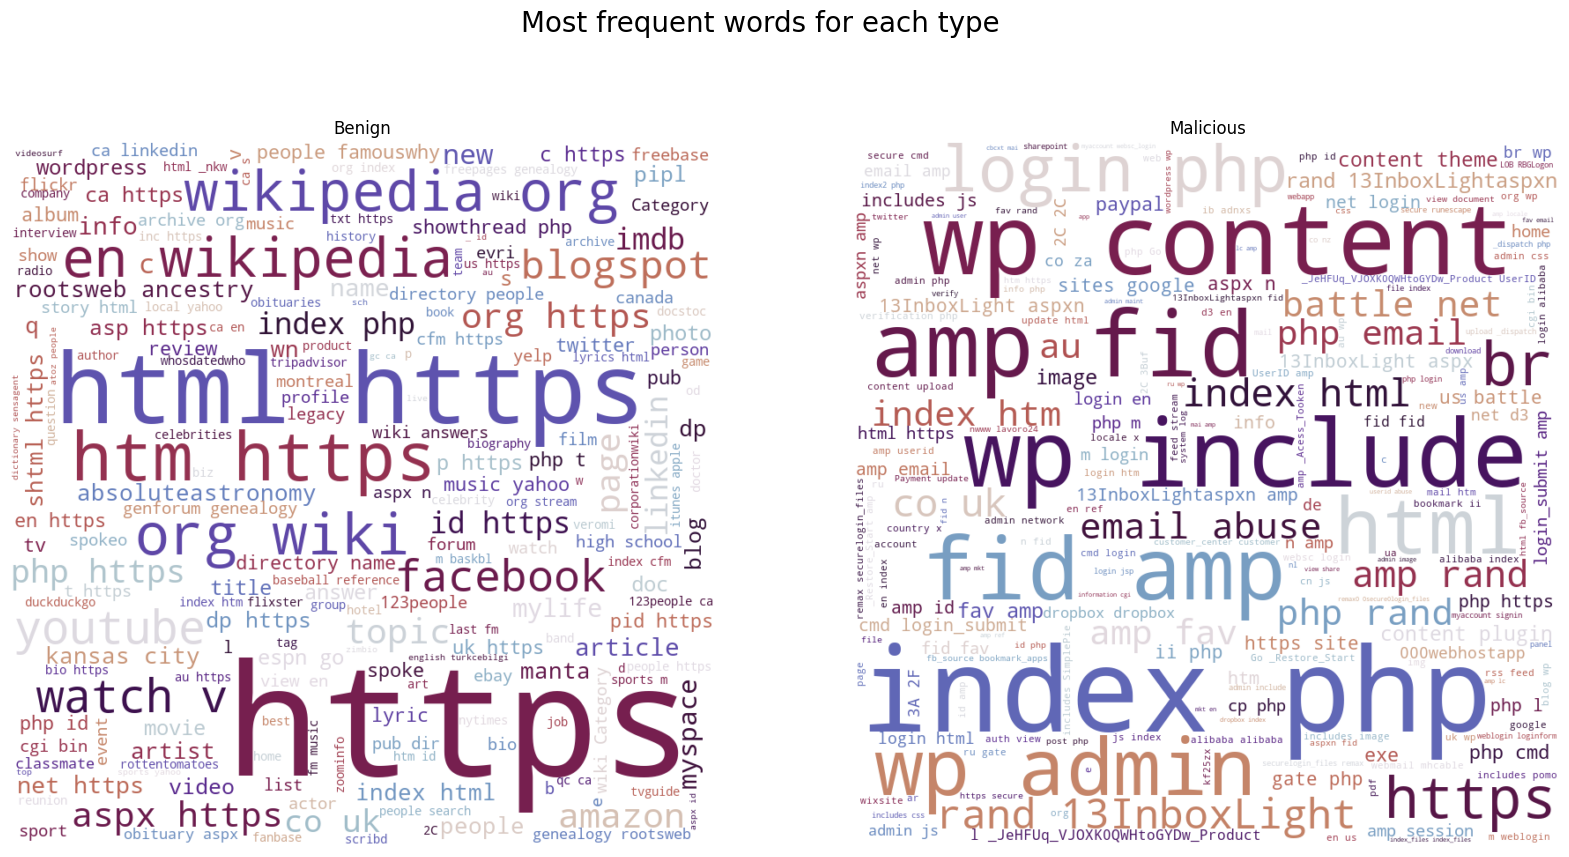

In [141]:
plt.figure(figsize=[20,10])
plt.suptitle('Most frequent words for each type',fontsize = 20)
benign_url = " ".join(i for i in df_benign.url)
wordcloud1 = WordCloud(width=800, height=800,colormap='twilight',background_color='white').generate(benign_url)
plt.subplot(1,2,1)
plt.title('Benign')
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')

malicious_url = " ".join(i for i in df_malicious.url)
wordcloud2 = WordCloud(width=800, height=800,colormap='twilight',background_color='white').generate(malicious_url)
plt.subplot(1,2,2)
plt.title('Malicious')
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
 
plt.show()

## insight
- The most frequent words: 
    - Benign: https, org, html and tools.
    - Malicious: index, php.

## Features Selection

In [21]:
def charCount(url, feature):
    return  url.count(feature)

In [22]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    df[a] = df['url'].apply(lambda i: charCount(i,a))

In [23]:
df

,url,label,result,@,?,-,=,.,#,%,+,$,!,*,",",//
0,https://www.heraldtribune.com/article/20110920...,benign,0,0,0,0,0,2,0,0,0,0,0,0,0,1
1,https://www.ssrsi.org/Family/educate/US/nah12.htm,benign,0,0,0,0,0,3,0,0,0,0,0,0,0,1
2,https://www.andrewcusack.com/2008/09/29/petit-...,benign,0,0,0,1,0,2,0,0,0,0,0,0,0,1
3,https://www.spoke.com/info/p6JJ2u1/HeatherReisman,benign,0,0,0,0,0,2,0,0,0,0,0,0,0,1
4,https://www.hockeydb.com/ihdb/stats/pdisplay.p...,benign,0,0,1,0,1,3,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,https://www.wizxpert.com/outlook-is-missing-in...,malicious,1,0,0,5,0,2,0,0,0,0,0,0,0,1
4996,http://erna.com.br/wp_include/newdocxb/9808f76...,malicious,1,0,0,0,0,2,0,0,0,0,0,0,0,1
4997,http://living4u.80port.net/zb/doc/file.index.h...,malicious,1,0,0,7,0,4,0,1,0,0,0,0,0,1
4998,http://spris.com/images/log.txt,malicious,1,0,0,0,0,2,0,0,0,0,0,0,0,1


In [24]:
All = df.groupby('label').mean()
result = All[['@','?','-','=','.','#','%','+','$','!','*',',','//']]
result['label']=['benign','malicious']
#"benign": 0, "defacement": 1, "phishing":2, "malware":3
result

,@,?,-,=,.,#,%,+,$,!,*,",",//,label
label,,,,,,,,,,,,,,
benign,0.000,0.1304,1.4332,0.1888,2.6492,0.000,0.0720,0.0900,0.0000,0.0016,0.0,0.0000,1.0000,benign
malicious,0.026,0.2100,0.5964,0.3952,2.5204,0.004,0.0776,0.0064,0.0004,0.0032,0.0,0.0164,1.0204,malicious


In [147]:
px.bar(data_frame=result,x='label',y=['?','=','.','@','//'],barmode='group',title='Average numbe of symbols for each type',color_discrete_map={'?':'#90caf9','=':'#e7cbcb','.':'#567995', '@':'#73a1c7','//':'#c47d7d'}).update_layout(title_x=0.5)

#color_discrete_map={'%':'#73a1c7','//':'#c47d7d'}
# blue,darkblue,royalblue,lightcyan


### Insight:
- Malicions URLs can have a lot of (@,?,=) symbol.

In [26]:
#https://dmitripavlutin.com/parse-url-javascript/
#https://docs.python.org/3/library/re.html
# re.search : Scan through string looking for the
# first location where the regular expression pattern produces a match,
# and return a corresponding match object. Return None if 
# no position in the string matches the pattern; note that
# this is different from finding a zero-length match at some point in the string.

In [27]:
# check if the url has a hostname or not
def HasHostname(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0
    

In [28]:
df['HasHostname'] = df['url'].apply(lambda i: HasHostname(i))

In [29]:
Host = pd.crosstab(df.label,df.HasHostname)
Host['label']=['benign','malicious']
Host.rename(columns={0:'no_HostName',1:'has_HostName'},inplace=True)

In [30]:
Host

HasHostname,no_HostName,has_HostName,label
label,,,
benign,0,2500,benign
malicious,3,2497,malicious


In [31]:
px.bar(data_frame=Host,x=Host.label,y=['has_HostName','no_HostName'],barmode='group',title='The numbe of hostname for each type',color_discrete_map={'has_HostName':'#c47d7d','no_HostName':'#73a1c7'}).update_layout(title_x=0.5)



### Insight:
- All the benign url have hostname.

In [32]:
#https://python.readthedocs.io/en/v2.7.2/library/urlparse.html
# scheme return either http or https or None
# IsHttps to check if the url is https
def IsHttps(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        return 1
    else:
        return 0

In [33]:
df['IsHttps'] = df['url'].apply(lambda i: IsHttps(i))

In [34]:
df

,url,label,result,@,?,-,=,.,#,%,+,$,!,*,",",//,HasHostname,IsHttps
0,https://www.heraldtribune.com/article/20110920...,benign,0,0,0,0,0,2,0,0,0,0,0,0,0,1,1,1
1,https://www.ssrsi.org/Family/educate/US/nah12.htm,benign,0,0,0,0,0,3,0,0,0,0,0,0,0,1,1,1
2,https://www.andrewcusack.com/2008/09/29/petit-...,benign,0,0,0,1,0,2,0,0,0,0,0,0,0,1,1,1
3,https://www.spoke.com/info/p6JJ2u1/HeatherReisman,benign,0,0,0,0,0,2,0,0,0,0,0,0,0,1,1,1
4,https://www.hockeydb.com/ihdb/stats/pdisplay.p...,benign,0,0,1,0,1,3,0,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,https://www.wizxpert.com/outlook-is-missing-in...,malicious,1,0,0,5,0,2,0,0,0,0,0,0,0,1,1,1
4996,http://erna.com.br/wp_include/newdocxb/9808f76...,malicious,1,0,0,0,0,2,0,0,0,0,0,0,0,1,1,0
4997,http://living4u.80port.net/zb/doc/file.index.h...,malicious,1,0,0,7,0,4,0,1,0,0,0,0,0,1,1,0
4998,http://spris.com/images/log.txt,malicious,1,0,0,0,0,2,0,0,0,0,0,0,0,1,1,0


In [35]:
https = pd.crosstab(df.label,df.IsHttps)
https['type']=['benign','malicious']
https.rename(columns={0:'is_not_Https',1:'is_Https'},inplace=True)

In [36]:
https

IsHttps,is_not_Https,is_Https,type
label,,,
benign,0,2500,benign
malicious,2337,163,malicious


In [37]:
px.bar(data_frame=https,x=https.type,y=['is_not_Https','is_Https'],barmode='group',title='The number of hostname for each type',color_discrete_map={'is_not_Https':'#c47d7d','is_Https':'#73a1c7'}).update_layout(title_x=0.5)



### Insights
- All the benign url must have https.
- Some of the malicous url contin https, this is due to the evolution of hackers.

In [38]:
# Count the number of digits in url (how many numbers there?)
def numberCount(url):
    numbers = 0
    for i in url:
        if i.isnumeric():
            numbers = numbers + 1
    return numbers

In [39]:
df['numberCount']= df['url'].apply(lambda i: numberCount(i))

In [40]:
df

,url,label,result,@,?,-,=,.,#,%,+,$,!,*,",",//,HasHostname,IsHttps,numberCount
0,https://www.heraldtribune.com/article/20110920...,benign,0,0,0,0,0,2,0,0,0,0,0,0,0,1,1,1,17
1,https://www.ssrsi.org/Family/educate/US/nah12.htm,benign,0,0,0,0,0,3,0,0,0,0,0,0,0,1,1,1,2
2,https://www.andrewcusack.com/2008/09/29/petit-...,benign,0,0,0,1,0,2,0,0,0,0,0,0,0,1,1,1,8
3,https://www.spoke.com/info/p6JJ2u1/HeatherReisman,benign,0,0,0,0,0,2,0,0,0,0,0,0,0,1,1,1,3
4,https://www.hockeydb.com/ihdb/stats/pdisplay.p...,benign,0,0,1,0,1,3,0,0,0,0,0,0,0,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,https://www.wizxpert.com/outlook-is-missing-in...,malicious,1,0,0,5,0,2,0,0,0,0,0,0,0,1,1,1,0
4996,http://erna.com.br/wp_include/newdocxb/9808f76...,malicious,1,0,0,0,0,2,0,0,0,0,0,0,0,1,1,0,22
4997,http://living4u.80port.net/zb/doc/file.index.h...,malicious,1,0,0,7,0,4,0,1,0,0,0,0,0,1,1,0,15
4998,http://spris.com/images/log.txt,malicious,1,0,0,0,0,2,0,0,0,0,0,0,0,1,1,0,0


In [41]:
All_num = df[['label','numberCount']].groupby('label').mean()
number = pd.DataFrame()
number['numberCount'] = All_num['numberCount']
number['type']=['benign','malicious']
#"benign": 0, "defacement": 1, "phishing":2, "malware":3
number

,numberCount,type
label,,
benign,3.2412,benign
malicious,7.0904,malicious


In [42]:
px.bar(data_frame=number,x=number.type,y=['numberCount'],barmode='group',title='The number of digits for each type',color_discrete_map={'numberCount':'#c47d7d'}).update_layout(title_x=0.5)



### Insight
- The number of digits increas in malicious. 
- The numbers that appear in benign may be due to the port number and username

In [43]:
# Count the number of alphabets in url (how many letter there?)
def alphabetCount(url):
    alphabets = 0
    for i in url:
        if i.isalpha():
            alphabets = alphabets + 1
    return alphabets

In [44]:
df['alphabetCount']= df['url'].apply(lambda i: alphabetCount(i))

In [45]:
df

,url,label,result,@,?,-,=,.,#,%,+,$,!,*,",",//,HasHostname,IsHttps,numberCount,alphabetCount
0,https://www.heraldtribune.com/article/20110920...,benign,0,0,0,0,0,2,0,0,0,0,0,0,0,1,1,1,17,38
1,https://www.ssrsi.org/Family/educate/US/nah12.htm,benign,0,0,0,0,0,3,0,0,0,0,0,0,0,1,1,1,2,37
2,https://www.andrewcusack.com/2008/09/29/petit-...,benign,0,0,0,1,0,2,0,0,0,0,0,0,0,1,1,1,8,37
3,https://www.spoke.com/info/p6JJ2u1/HeatherReisman,benign,0,0,0,0,0,2,0,0,0,0,0,0,0,1,1,1,3,38
4,https://www.hockeydb.com/ihdb/stats/pdisplay.p...,benign,0,0,1,0,1,3,0,0,0,0,0,0,0,1,1,1,5,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,https://www.wizxpert.com/outlook-is-missing-in...,malicious,1,0,0,5,0,2,0,0,0,0,0,0,0,1,1,1,0,54
4996,http://erna.com.br/wp_include/newdocxb/9808f76...,malicious,1,0,0,0,0,2,0,0,0,0,0,0,0,1,1,0,22,40
4997,http://living4u.80port.net/zb/doc/file.index.h...,malicious,1,0,0,7,0,4,0,1,0,0,0,0,0,1,1,0,15,166
4998,http://spris.com/images/log.txt,malicious,1,0,0,0,0,2,0,0,0,0,0,0,0,1,1,0,0,24


In [46]:
All_alph = df[['label','alphabetCount']].groupby('label').mean()
letters = pd.DataFrame()
letters['alphabetCount'] = All_alph['alphabetCount']
letters['type']=['benign','malicious']

letters

,alphabetCount,type
label,,
benign,44.4884,benign
malicious,48.5888,malicious


In [47]:
px.bar(data_frame=letters,x=letters.type,y=['alphabetCount'],barmode='group',title='The number of letters for each type',color_discrete_map={'alphabetCount':'#c47d7d'}).update_layout(title_x=0.5)



### Insight
- The possibility of the url to be malicious is greater if the number of characters is large.

In [48]:
# Check if the url conatins the short url (tinyURL)

def shortUrl(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [49]:
df['shortUrl'] = df['url'].apply(lambda x: shortUrl(x))

In [50]:
df

,url,label,result,@,?,-,=,.,#,%,...,$,!,*,",",//,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl
0,https://www.heraldtribune.com/article/20110920...,benign,0,0,0,0,0,2,0,0,...,0,0,0,0,1,1,1,17,38,0
1,https://www.ssrsi.org/Family/educate/US/nah12.htm,benign,0,0,0,0,0,3,0,0,...,0,0,0,0,1,1,1,2,37,0
2,https://www.andrewcusack.com/2008/09/29/petit-...,benign,0,0,0,1,0,2,0,0,...,0,0,0,0,1,1,1,8,37,0
3,https://www.spoke.com/info/p6JJ2u1/HeatherReisman,benign,0,0,0,0,0,2,0,0,...,0,0,0,0,1,1,1,3,38,0
4,https://www.hockeydb.com/ihdb/stats/pdisplay.p...,benign,0,0,1,0,1,3,0,0,...,0,0,0,0,1,1,1,5,42,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,https://www.wizxpert.com/outlook-is-missing-in...,malicious,1,0,0,5,0,2,0,0,...,0,0,0,0,1,1,1,0,54,1
4996,http://erna.com.br/wp_include/newdocxb/9808f76...,malicious,1,0,0,0,0,2,0,0,...,0,0,0,0,1,1,0,22,40,0
4997,http://living4u.80port.net/zb/doc/file.index.h...,malicious,1,0,0,7,0,4,0,1,...,0,0,0,0,1,1,0,15,166,0
4998,http://spris.com/images/log.txt,malicious,1,0,0,0,0,2,0,0,...,0,0,0,0,1,1,0,0,24,0


In [51]:
shortUrl = pd.crosstab(df.label,df.shortUrl)
shortUrl['type']=['benign','malicious']
shortUrl.rename(columns={0:'not_use_ShorteningServices',1:'use_ShorteningServices'},inplace=True)

In [52]:
shortUrl

shortUrl,not_use_ShorteningServices,use_ShorteningServices,type
label,,,
benign,2290,210,benign
malicious,2346,154,malicious


In [53]:
px.bar(data_frame=shortUrl,x=shortUrl.type,y=['not_use_ShorteningServices','use_ShorteningServices'],barmode='group',title='The number of Shortening Services for each type',color_discrete_map={'not_use_ShorteningServices':'#c47d7d','use_ShorteningServices':'#73a1c7'}).update_layout(title_x=0.5)


### Insight:
- Not all URL shorting is malicious or dangerous.

In [54]:
# check if url contains IPv4 or IPv6
def ipAddress(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [55]:
df['ipAddress'] = df['url'].apply(lambda i: ipAddress(i))

In [56]:
df

,url,label,result,@,?,-,=,.,#,%,...,!,*,",",//,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl,ipAddress
0,https://www.heraldtribune.com/article/20110920...,benign,0,0,0,0,0,2,0,0,...,0,0,0,1,1,1,17,38,0,0
1,https://www.ssrsi.org/Family/educate/US/nah12.htm,benign,0,0,0,0,0,3,0,0,...,0,0,0,1,1,1,2,37,0,0
2,https://www.andrewcusack.com/2008/09/29/petit-...,benign,0,0,0,1,0,2,0,0,...,0,0,0,1,1,1,8,37,0,0
3,https://www.spoke.com/info/p6JJ2u1/HeatherReisman,benign,0,0,0,0,0,2,0,0,...,0,0,0,1,1,1,3,38,0,0
4,https://www.hockeydb.com/ihdb/stats/pdisplay.p...,benign,0,0,1,0,1,3,0,0,...,0,0,0,1,1,1,5,42,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,https://www.wizxpert.com/outlook-is-missing-in...,malicious,1,0,0,5,0,2,0,0,...,0,0,0,1,1,1,0,54,1,0
4996,http://erna.com.br/wp_include/newdocxb/9808f76...,malicious,1,0,0,0,0,2,0,0,...,0,0,0,1,1,0,22,40,0,0
4997,http://living4u.80port.net/zb/doc/file.index.h...,malicious,1,0,0,7,0,4,0,1,...,0,0,0,1,1,0,15,166,0,0
4998,http://spris.com/images/log.txt,malicious,1,0,0,0,0,2,0,0,...,0,0,0,1,1,0,0,24,0,0


In [57]:
ipAddress = pd.crosstab(df.label,df.ipAddress)
ipAddress['type']=['benign','malicious']
ipAddress.rename(columns={0:'not_use_ipAddress',1:'use_ipAddress'},inplace=True)

In [58]:
ipAddress

ipAddress,not_use_ipAddress,use_ipAddress,type
label,,,
benign,2499,1,benign
malicious,2410,90,malicious


In [59]:
px.bar(data_frame=ipAddress,x=ipAddress.type,y=['not_use_ipAddress','use_ipAddress'],barmode='group',title='The number of ipAddress for each type',color_discrete_map={'not_use_ipAddress':'#c47d7d','use_ipAddress':'#73a1c7'}).update_layout(title_x=0.5)




### insight 
- The IP address appear in malicious.

In [60]:
# https://pypi.org/project/python-whois/
# https://www.geeksforgeeks.org/how-to-convert-datetime-to-date-in-python/ 
'''
To get domain age:
1- get domain name using whois and urlparse
2- If url has domain name ==> extract the creation and expiration dates ==> check if the age is more than 12

if age > 12 less phishing possibility  
else higher phishing possibility 
'''

'\nTo get domain age:\n1- get domain name using whois and urlparse\n2- If url has domain name ==> extract the creation and expiration dates ==> check if the age is more than 12\n\nif age > 12 less phishing possibility  \nelse higher phishing possibility \n'

In [61]:
def ageLess12Mon(url):
  try:
    domain_name = whois.whois(urlparse(url).netloc) 
    creation_date = domain_name.creation_date
    expiration_date = domain_name.expiration_date
    if (isinstance(creation_date,str) or isinstance(expiration_date,str)):
      try:
        creation_date = datetime.strptime(creation_date,'%Y-%m-%d')
        expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
      except:
        return 1
    if ((expiration_date is None) or (creation_date is None)):
        return 1
    else:
      ageofdomain = abs((expiration_date - creation_date).days)
      if ((ageofdomain/30) < 12):
        age = 1
      else:
        age = 0
  except:
      age = 1
 
  return age

In [62]:
df['ageLess12Mon'] = df['url'].apply(lambda i: ageLess12Mon(i))

In [63]:
df

,url,label,result,@,?,-,=,.,#,%,...,*,",",//,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon
0,https://www.heraldtribune.com/article/20110920...,benign,0,0,0,0,0,2,0,0,...,0,0,1,1,1,17,38,0,0,1
1,https://www.ssrsi.org/Family/educate/US/nah12.htm,benign,0,0,0,0,0,3,0,0,...,0,0,1,1,1,2,37,0,0,1
2,https://www.andrewcusack.com/2008/09/29/petit-...,benign,0,0,0,1,0,2,0,0,...,0,0,1,1,1,8,37,0,0,1
3,https://www.spoke.com/info/p6JJ2u1/HeatherReisman,benign,0,0,0,0,0,2,0,0,...,0,0,1,1,1,3,38,0,0,1
4,https://www.hockeydb.com/ihdb/stats/pdisplay.p...,benign,0,0,1,0,1,3,0,0,...,0,0,1,1,1,5,42,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,https://www.wizxpert.com/outlook-is-missing-in...,malicious,1,0,0,5,0,2,0,0,...,0,0,1,1,1,0,54,1,0,1
4996,http://erna.com.br/wp_include/newdocxb/9808f76...,malicious,1,0,0,0,0,2,0,0,...,0,0,1,1,0,22,40,0,0,1
4997,http://living4u.80port.net/zb/doc/file.index.h...,malicious,1,0,0,7,0,4,0,1,...,0,0,1,1,0,15,166,0,0,1
4998,http://spris.com/images/log.txt,malicious,1,0,0,0,0,2,0,0,...,0,0,1,1,0,0,24,0,0,1


In [64]:
ageLess12Mon = pd.crosstab(df.label,df.ageLess12Mon)
ageLess12Mon['type']=['benign','malicious']
ageLess12Mon.rename(columns={0:'ageMore12Mon',1:'ageLess12Mon'},inplace=True)

In [65]:
ageLess12Mon

ageLess12Mon,ageLess12Mon,type
label,,
benign,2500,benign
malicious,2500,malicious


In [66]:
px.bar(data_frame=ageLess12Mon,x=ageLess12Mon.type,y=['ageLess12Mon'],barmode='group',title='The number of age Less 12 Month for each type',color_discrete_map={'ageLess12Mon':'#c47d7d'}).update_layout(title_x=0.5)



In [67]:
'''
To get domain end:
1- get domain name using whois and urlparse
2- If url has domain name ==> extract the expiration date ==> check if the end is less than 6

if end > 6 less phishing possibility  
else higher phishing possibility 
'''

'\nTo get domain end:\n1- get domain name using whois and urlparse\n2- If url has domain name ==> extract the expiration date ==> check if the end is less than 6\n\nif end > 6 less phishing possibility  \nelse higher phishing possibility \n'

In [68]:
def endLess6Mon(url):
  try:
    domain_name = whois.whois(urlparse(url).netloc)
    expiration_date = domain_name.expiration_date
    if isinstance(expiration_date,str):
      try:
        expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
      except:
        return 1
    if (expiration_date is None):
        return 1
    else:
      today = datetime.now()
      end = abs((expiration_date - today).days)
      if ((end/30) < 6):
        end = 1
      else:
        end = 0
  except:
    end = 1

  return end

In [69]:
df['endLess6Mon'] = df['url'].apply(lambda i: endLess6Mon(i))

In [70]:
df

,url,label,result,@,?,-,=,.,#,%,...,",",//,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon
0,https://www.heraldtribune.com/article/20110920...,benign,0,0,0,0,0,2,0,0,...,0,1,1,1,17,38,0,0,1,1
1,https://www.ssrsi.org/Family/educate/US/nah12.htm,benign,0,0,0,0,0,3,0,0,...,0,1,1,1,2,37,0,0,1,1
2,https://www.andrewcusack.com/2008/09/29/petit-...,benign,0,0,0,1,0,2,0,0,...,0,1,1,1,8,37,0,0,1,1
3,https://www.spoke.com/info/p6JJ2u1/HeatherReisman,benign,0,0,0,0,0,2,0,0,...,0,1,1,1,3,38,0,0,1,1
4,https://www.hockeydb.com/ihdb/stats/pdisplay.p...,benign,0,0,1,0,1,3,0,0,...,0,1,1,1,5,42,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,https://www.wizxpert.com/outlook-is-missing-in...,malicious,1,0,0,5,0,2,0,0,...,0,1,1,1,0,54,1,0,1,1
4996,http://erna.com.br/wp_include/newdocxb/9808f76...,malicious,1,0,0,0,0,2,0,0,...,0,1,1,0,22,40,0,0,1,1
4997,http://living4u.80port.net/zb/doc/file.index.h...,malicious,1,0,0,7,0,4,0,1,...,0,1,1,0,15,166,0,0,1,1
4998,http://spris.com/images/log.txt,malicious,1,0,0,0,0,2,0,0,...,0,1,1,0,0,24,0,0,1,1


In [71]:
endLess6Mon = pd.crosstab(df.label,df.endLess6Mon)
endLess6Mon['type']=['benign','malicious']
endLess6Mon.rename(columns={0:'ageMore6Mon',1:'endLess6Mon'},inplace=True)
endLess6Mon

endLess6Mon,endLess6Mon,type
label,,
benign,2500,benign
malicious,2500,malicious


In [72]:
px.bar(data_frame=endLess6Mon,x=endLess6Mon.type,y=['endLess6Mon'],barmode='group',title='The number of end Less 6 Month for each type',color_discrete_map={'endLess6Mon':'#c47d7d'}).update_layout(title_x=0.5)



In [73]:
# phishing sites use iframe tags to create invisible links that users maybe click it
def hasIfram(url):
    try:
        response = requests.get(url)
        if re.findall(r"[<iframe>|<frameBorder>]", response.text):
            return 0
        else:
            return 1
    except:
        return 1
    

In [74]:
df['hasIfram'] = df['url'].apply(lambda i: hasIfram(i))

In [75]:
df

,url,label,result,@,?,-,=,.,#,%,...,//,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon,hasIfram
0,https://www.heraldtribune.com/article/20110920...,benign,0,0,0,0,0,2,0,0,...,1,1,1,17,38,0,0,1,1,0
1,https://www.ssrsi.org/Family/educate/US/nah12.htm,benign,0,0,0,0,0,3,0,0,...,1,1,1,2,37,0,0,1,1,0
2,https://www.andrewcusack.com/2008/09/29/petit-...,benign,0,0,0,1,0,2,0,0,...,1,1,1,8,37,0,0,1,1,0
3,https://www.spoke.com/info/p6JJ2u1/HeatherReisman,benign,0,0,0,0,0,2,0,0,...,1,1,1,3,38,0,0,1,1,0
4,https://www.hockeydb.com/ihdb/stats/pdisplay.p...,benign,0,0,1,0,1,3,0,0,...,1,1,1,5,42,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,https://www.wizxpert.com/outlook-is-missing-in...,malicious,1,0,0,5,0,2,0,0,...,1,1,1,0,54,1,0,1,1,0
4996,http://erna.com.br/wp_include/newdocxb/9808f76...,malicious,1,0,0,0,0,2,0,0,...,1,1,0,22,40,0,0,1,1,1
4997,http://living4u.80port.net/zb/doc/file.index.h...,malicious,1,0,0,7,0,4,0,1,...,1,1,0,15,166,0,0,1,1,1
4998,http://spris.com/images/log.txt,malicious,1,0,0,0,0,2,0,0,...,1,1,0,0,24,0,0,1,1,1


In [76]:
hasIfram = pd.crosstab(df.label, df.hasIfram)
hasIfram['type']=['benign','malicious']
hasIfram.rename(columns={0:'not_has_Ifram',1:'has_Ifram'},inplace=True)
hasIfram

hasIfram,not_has_Ifram,has_Ifram,type
label,,,
benign,441,2059,benign
malicious,1070,1430,malicious


In [77]:
px.bar(data_frame=hasIfram,x=hasIfram.type,y=['not_has_Ifram','has_Ifram'],barmode='group',title='The number of URL has Ifram for each type',color_discrete_map={'not_has_Ifram':'#c47d7d','has_Ifram':'#73a1c7'}).update_layout(title_x=0.5)



### Insight:
- Benign type must have ifram. 

In [78]:
# https://www.google.com/url?sa=i&url=https%3A%2F%2Fsecurity.stackexchange.com%2Fquestions%2F41527%2Fis-the-web-browser-status-bar-always-trustable&psig=AOvVaw2cVoaiFrxGEx2u2o6La9e4&ust=1677095551544000&source=images&cd=vfe&ved=0CBAQjRxqFwoTCKi81vaxp_0CFQAAAAAdAAAAABAD
# phishing sites use mouseover event from javascript to hide fake url
def hasMouseOver(url): 
  try:
    response = requests.get(url)
    if re.findall("<script>.+onmouseover.+</script>", response.text):
      return 1
    else:
      return 0
  except:
        return 1

In [79]:
df['hasMouseOver'] = df['url'].apply(lambda i: hasMouseOver(i))

In [80]:
df

,url,label,result,@,?,-,=,.,#,%,...,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon,hasIfram,hasMouseOver
0,https://www.heraldtribune.com/article/20110920...,benign,0,0,0,0,0,2,0,0,...,1,1,17,38,0,0,1,1,0,0
1,https://www.ssrsi.org/Family/educate/US/nah12.htm,benign,0,0,0,0,0,3,0,0,...,1,1,2,37,0,0,1,1,0,0
2,https://www.andrewcusack.com/2008/09/29/petit-...,benign,0,0,0,1,0,2,0,0,...,1,1,8,37,0,0,1,1,0,0
3,https://www.spoke.com/info/p6JJ2u1/HeatherReisman,benign,0,0,0,0,0,2,0,0,...,1,1,3,38,0,0,1,1,0,0
4,https://www.hockeydb.com/ihdb/stats/pdisplay.p...,benign,0,0,1,0,1,3,0,0,...,1,1,5,42,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,https://www.wizxpert.com/outlook-is-missing-in...,malicious,1,0,0,5,0,2,0,0,...,1,1,0,54,1,0,1,1,0,1
4996,http://erna.com.br/wp_include/newdocxb/9808f76...,malicious,1,0,0,0,0,2,0,0,...,1,0,22,40,0,0,1,1,1,1
4997,http://living4u.80port.net/zb/doc/file.index.h...,malicious,1,0,0,7,0,4,0,1,...,1,0,15,166,0,0,1,1,1,1
4998,http://spris.com/images/log.txt,malicious,1,0,0,0,0,2,0,0,...,1,0,0,24,0,0,1,1,1,1


In [81]:
hasMouseOver = pd.crosstab(df.label,df.hasMouseOver)
hasMouseOver['type']=['benign','malicious']
hasMouseOver.rename(columns={0:'not_has_Mouse_Over',1:'has_Mouse_Over'},inplace=True)
hasMouseOver

hasMouseOver,not_has_Mouse_Over,has_Mouse_Over,type
label,,,
benign,208,2292,benign
malicious,0,2500,malicious


In [82]:
px.bar(data_frame=hasMouseOver,x=hasMouseOver.type,y=['has_Mouse_Over'],barmode='group',title='The number of URL has Mouse Over for each type',color_discrete_map={'has_Mouse_Over':'#c47d7d'}).update_layout(title_x=0.5)
#color_discrete_map={'%':'#73a1c7','//':'#c47d7d'}


In [83]:
# This part explained in the paper, disabled the right click option so the user cann't incpect the webpage
def disabledRightClick(url): 
  try:
    response = requests.get(url)
    if re.findall(r"event.button ?== ?2", response.text):
      return 0
    else:
      return 1
  except:
        return 1

In [84]:
df['disabledRightClick'] = df['url'].apply(lambda i: disabledRightClick(i))

In [85]:
df

,url,label,result,@,?,-,=,.,#,%,...,IsHttps,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon,hasIfram,hasMouseOver,disabledRightClick
0,https://www.heraldtribune.com/article/20110920...,benign,0,0,0,0,0,2,0,0,...,1,17,38,0,0,1,1,0,0,1
1,https://www.ssrsi.org/Family/educate/US/nah12.htm,benign,0,0,0,0,0,3,0,0,...,1,2,37,0,0,1,1,0,0,1
2,https://www.andrewcusack.com/2008/09/29/petit-...,benign,0,0,0,1,0,2,0,0,...,1,8,37,0,0,1,1,0,0,1
3,https://www.spoke.com/info/p6JJ2u1/HeatherReisman,benign,0,0,0,0,0,2,0,0,...,1,3,38,0,0,1,1,0,0,1
4,https://www.hockeydb.com/ihdb/stats/pdisplay.p...,benign,0,0,1,0,1,3,0,0,...,1,5,42,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,https://www.wizxpert.com/outlook-is-missing-in...,malicious,1,0,0,5,0,2,0,0,...,1,0,54,1,0,1,1,0,1,1
4996,http://erna.com.br/wp_include/newdocxb/9808f76...,malicious,1,0,0,0,0,2,0,0,...,0,22,40,0,0,1,1,1,1,1
4997,http://living4u.80port.net/zb/doc/file.index.h...,malicious,1,0,0,7,0,4,0,1,...,0,15,166,0,0,1,1,1,1,1
4998,http://spris.com/images/log.txt,malicious,1,0,0,0,0,2,0,0,...,0,0,24,0,0,1,1,1,1,1


In [86]:
disabledRightClick = pd.crosstab(df.label,df.disabledRightClick)
disabledRightClick['type']=['benign','malicious']
disabledRightClick.rename(columns={0:'not_has_disabled_RightClick',1:'has_disabled_RightClick'},inplace=True)
disabledRightClick

disabledRightClick,has_disabled_RightClick,type
label,,
benign,2500,benign
malicious,2500,malicious


In [87]:
px.bar(data_frame=disabledRightClick,x=disabledRightClick.type,y=['has_disabled_RightClick'],barmode='group',title='The number of URL has disabled RightClick for each type',color_discrete_map={'has_disabled_RightClick':'#c47d7d'}).update_layout(title_x=0.5)



In [88]:
# This part explained in the paper, multiple redirect webpages have a high possibility to be a phising websits
def isMultiDirected(url): 
  try:
    response = requests.get(url)
    if len(response.history) <= 2:
      return 0
    else:
      return 1
  except:
        return 1

In [89]:
df['isMultiDirected'] = df['url'].apply(lambda i: isMultiDirected(i))

In [90]:
df

,url,label,result,@,?,-,=,.,#,%,...,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon,hasIfram,hasMouseOver,disabledRightClick,isMultiDirected
0,https://www.heraldtribune.com/article/20110920...,benign,0,0,0,0,0,2,0,0,...,17,38,0,0,1,1,0,0,1,0
1,https://www.ssrsi.org/Family/educate/US/nah12.htm,benign,0,0,0,0,0,3,0,0,...,2,37,0,0,1,1,0,0,1,0
2,https://www.andrewcusack.com/2008/09/29/petit-...,benign,0,0,0,1,0,2,0,0,...,8,37,0,0,1,1,0,0,1,0
3,https://www.spoke.com/info/p6JJ2u1/HeatherReisman,benign,0,0,0,0,0,2,0,0,...,3,38,0,0,1,1,0,0,1,0
4,https://www.hockeydb.com/ihdb/stats/pdisplay.p...,benign,0,0,1,0,1,3,0,0,...,5,42,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,https://www.wizxpert.com/outlook-is-missing-in...,malicious,1,0,0,5,0,2,0,0,...,0,54,1,0,1,1,0,1,1,1
4996,http://erna.com.br/wp_include/newdocxb/9808f76...,malicious,1,0,0,0,0,2,0,0,...,22,40,0,0,1,1,1,1,1,1
4997,http://living4u.80port.net/zb/doc/file.index.h...,malicious,1,0,0,7,0,4,0,1,...,15,166,0,0,1,1,1,1,1,1
4998,http://spris.com/images/log.txt,malicious,1,0,0,0,0,2,0,0,...,0,24,0,0,1,1,1,1,1,1


In [91]:
isMultiDirected = pd.crosstab(df.label,df.isMultiDirected)
isMultiDirected['type']=['benign','malicious']
isMultiDirected.rename(columns={0:'is_not_Multi_Directed',1:'is_Multi_Directed'},inplace=True)
isMultiDirected

isMultiDirected,is_not_Multi_Directed,is_Multi_Directed,type
label,,,
benign,219,2281,benign
malicious,0,2500,malicious


In [92]:
px.bar(data_frame=isMultiDirected,x=isMultiDirected.type,y=['is_Multi_Directed'],barmode='group',title='The number of URL has Multi Directed for each type',color_discrete_map={'is_Multi_Directed':'#c47d7d'}).update_layout(title_x=0.5)



# Models

In [93]:
modelData = df.copy()

In [94]:
modelData

,url,label,result,@,?,-,=,.,#,%,...,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon,hasIfram,hasMouseOver,disabledRightClick,isMultiDirected
0,https://www.heraldtribune.com/article/20110920...,benign,0,0,0,0,0,2,0,0,...,17,38,0,0,1,1,0,0,1,0
1,https://www.ssrsi.org/Family/educate/US/nah12.htm,benign,0,0,0,0,0,3,0,0,...,2,37,0,0,1,1,0,0,1,0
2,https://www.andrewcusack.com/2008/09/29/petit-...,benign,0,0,0,1,0,2,0,0,...,8,37,0,0,1,1,0,0,1,0
3,https://www.spoke.com/info/p6JJ2u1/HeatherReisman,benign,0,0,0,0,0,2,0,0,...,3,38,0,0,1,1,0,0,1,0
4,https://www.hockeydb.com/ihdb/stats/pdisplay.p...,benign,0,0,1,0,1,3,0,0,...,5,42,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,https://www.wizxpert.com/outlook-is-missing-in...,malicious,1,0,0,5,0,2,0,0,...,0,54,1,0,1,1,0,1,1,1
4996,http://erna.com.br/wp_include/newdocxb/9808f76...,malicious,1,0,0,0,0,2,0,0,...,22,40,0,0,1,1,1,1,1,1
4997,http://living4u.80port.net/zb/doc/file.index.h...,malicious,1,0,0,7,0,4,0,1,...,15,166,0,0,1,1,1,1,1,1
4998,http://spris.com/images/log.txt,malicious,1,0,0,0,0,2,0,0,...,0,24,0,0,1,1,1,1,1,1


In [95]:
df['label'] = df['label'].map({"benign": 0, 'malicious':1})

In [96]:
modelData['label'] = modelData['label'].map({"benign": 0, 'malicious':1})

In [97]:
#px.imshow(df.corr(),text_auto=True,aspect="auto",template="plotly_white").update_layout(title_text='Correlation Map',title_x=0.5,height=600,width=650).show()
#sns.heatmap(df.corr(),cmap='RdBu',annot=True,fmt=".1f",vmin=-1, vmax=1)



In [98]:
df.head()

,url,label,result,@,?,-,=,.,#,%,...,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon,hasIfram,hasMouseOver,disabledRightClick,isMultiDirected
0,https://www.heraldtribune.com/article/20110920...,0,0,0,0,0,0,2,0,0,...,17,38,0,0,1,1,0,0,1,0
1,https://www.ssrsi.org/Family/educate/US/nah12.htm,0,0,0,0,0,0,3,0,0,...,2,37,0,0,1,1,0,0,1,0
2,https://www.andrewcusack.com/2008/09/29/petit-...,0,0,0,0,1,0,2,0,0,...,8,37,0,0,1,1,0,0,1,0
3,https://www.spoke.com/info/p6JJ2u1/HeatherReisman,0,0,0,0,0,0,2,0,0,...,3,38,0,0,1,1,0,0,1,0
4,https://www.hockeydb.com/ihdb/stats/pdisplay.p...,0,0,0,1,0,1,3,0,0,...,5,42,0,0,1,1,0,0,1,0


In [99]:
#df.to_csv('finalURL_version3.csv')

In [100]:
#['ageLess12Mon','endLess6Mon','hasMouseOver','disabledRightClick','isMultiDirected']

In [101]:
#modelData['label'] = modelData['label'].map({0: 0, 1: 1, 2:1, 3:1})

In [102]:
#modelData['label']

In [112]:
X = modelData.drop(columns=['url','label','result'],axis=1)
y = modelData['label']

In [113]:
X.head()

,@,?,-,=,.,#,%,+,$,!,...,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon,hasIfram,hasMouseOver,disabledRightClick,isMultiDirected
0,0,0,0,0,2,0,0,0,0,0,...,17,38,0,0,1,1,0,0,1,0
1,0,0,0,0,3,0,0,0,0,0,...,2,37,0,0,1,1,0,0,1,0
2,0,0,1,0,2,0,0,0,0,0,...,8,37,0,0,1,1,0,0,1,0
3,0,0,0,0,2,0,0,0,0,0,...,3,38,0,0,1,1,0,0,1,0
4,0,1,0,1,3,0,0,0,0,0,...,5,42,0,0,1,1,0,0,1,0


In [114]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [115]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
@,5000.0,0.0130,0.115038,0.0,0.0,0.0,0.0,2.0
?,5000.0,0.1702,0.411905,0.0,0.0,0.0,0.0,3.0
-,5000.0,1.0148,2.330594,0.0,0.0,0.0,1.0,27.0
=,5000.0,0.2920,0.976180,0.0,0.0,0.0,0.0,15.0
.,5000.0,2.5848,1.502951,1.0,2.0,2.0,3.0,24.0
#,5000.0,0.0020,0.044681,0.0,0.0,0.0,0.0,1.0
%,5000.0,0.0748,0.792799,0.0,0.0,0.0,0.0,29.0
+,5000.0,0.0482,0.473203,0.0,0.0,0.0,0.0,12.0
$,5000.0,0.0002,0.014142,0.0,0.0,0.0,0.0,1.0
!,5000.0,0.0024,0.077430,0.0,0.0,0.0,0.0,4.0


In [116]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [117]:
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 20)
print("The shape of X_train is      ", X_train.shape)
print("The shape of X_test is       ",X_test.shape)
print("The shape of y_train is      ",y_train.shape)
print("The shape of y_test is       ",y_test.shape)



The shape of X_train is       (4000, 25)
The shape of X_test is        (1000, 25)
The shape of y_train is       (4000,)
The shape of y_test is        (1000,)


In [118]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

--------------------Start-----------------
-----Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  97.20%  
Train Accuracy :  99.62%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       512
           1       0.97      0.97      0.97       488

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

             Confusion_matrix 


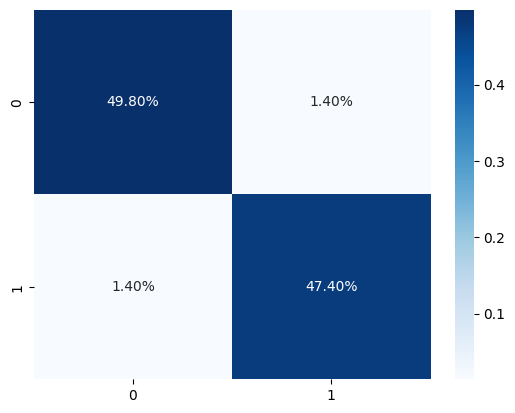

----------------- End --------------
--------------------Start-----------------
-----Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  98.30%  
Train Accuracy :  99.62%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       512
           1       0.99      0.97      0.98       488

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

             Confusion_matrix 


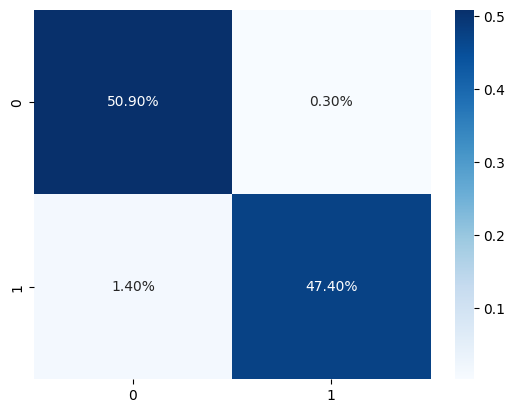

----------------- End --------------
--------------------Start-----------------
-----Model => <class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
Test Accuracy :  97.40%  
Train Accuracy :  97.78%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       512
           1       0.99      0.95      0.97       488

    accuracy                           0.97      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

             Confusion_matrix 


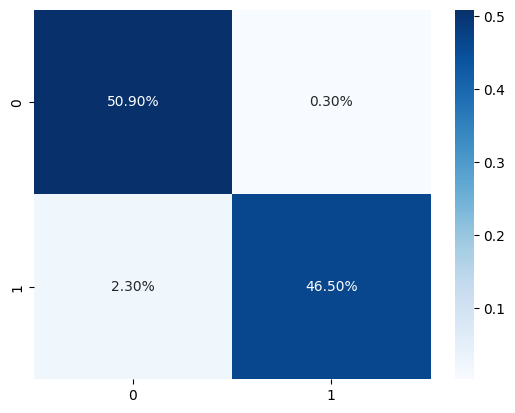

----------------- End --------------
--------------------Start-----------------
-----Model => <class 'sklearn.linear_model._logistic.LogisticRegression'> 
Test Accuracy :  97.30%  
Train Accuracy :  97.50%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       512
           1       0.99      0.95      0.97       488

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

             Confusion_matrix 


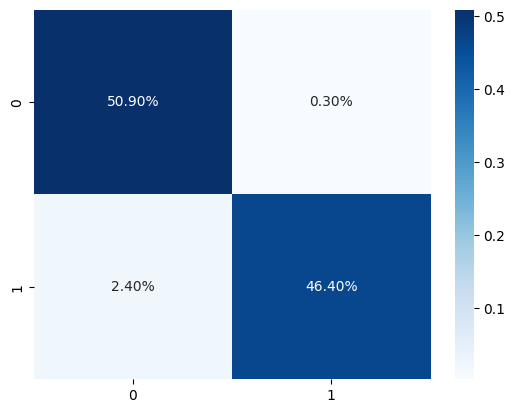

----------------- End --------------
--------------------Start-----------------
-----Model => <class 'sklearn.ensemble._gb.GradientBoostingClassifier'> 
Test Accuracy :  97.60%  
Train Accuracy :  98.22%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       512
           1       0.99      0.96      0.97       488

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

             Confusion_matrix 


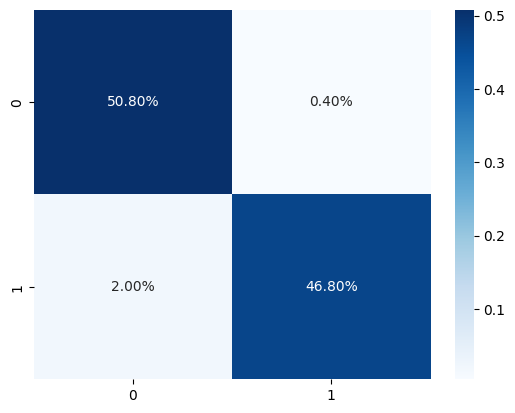

----------------- End --------------


In [119]:
models = [DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier,LogisticRegression,GradientBoostingClassifier]
accuracy_test=[]
nameModels = ['DecisionTreeClassifier','RandomForestClassifier','KNeighborsClassifier','LogisticRegression','GradientBoostingClassifier']
f1Score = []
recallScore = []
precisionScore = []
for m in models:
    print("--------------------Start-----------------")
    print('-----Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    f1 = f1_score(pred, y_test)
    recall = recall_score(pred, y_test)
    precision = precision_score(pred, y_test)
    
    
    train_yhat = model_.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    
    
    accuracy_test.append(acc)
    f1Score.append(f1)
    recallScore.append(recall)
    precisionScore.append(precision)
    
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('Train Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(train_acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%',cmap='Blues')
    plt.show()
    print('\033[31m----------------- End --------------\033[0m')

In [136]:
print('acc = {}'.format(accuracy_test))
print('F1 = {}'.format(f1Score))
print('recall = {}'.format(recallScore))
print('precision = {}'.format(precisionScore))
print('Models = {}'.format(nameModels))

acc = [0.972, 0.983, 0.974, 0.973, 0.976]
F1 = [0.9713114754098361, 0.9823834196891191, 0.9728033472803348, 0.9717277486910995, 0.9749999999999999]
recall = [0.9713114754098361, 0.9937106918238994, 0.9935897435897436, 0.9935760171306209, 0.9915254237288136]
precision = [0.9713114754098361, 0.9713114754098361, 0.9528688524590164, 0.9508196721311475, 0.9590163934426229]
Models = ['DecisionTreeClassifier', 'RandomForestClassifier', 'KNeighborsClassifier', 'LogisticRegression', 'GradientBoostingClassifier']


In [137]:
modelDetil = pd.DataFrame()
modelDetil['Model']=nameModels
modelDetil['acc']=accuracy_test
modelDetil['F1']=f1Score
modelDetil['recall']=recallScore
modelDetil['precision']=precisionScore
modelDetil

,Model,acc,F1,recall,precision
0,DecisionTreeClassifier,0.972,0.971311,0.971311,0.971311
1,RandomForestClassifier,0.983,0.982383,0.993711,0.971311
2,KNeighborsClassifier,0.974,0.972803,0.993590,0.952869
3,LogisticRegression,0.973,0.971728,0.993576,0.950820
4,GradientBoostingClassifier,0.976,0.975000,0.991525,0.959016


In [138]:
px.bar(data_frame=modelDetil,x='Model',y=['acc','F1','recall','precision'],barmode='group',title='comparison models',color_discrete_map={'acc':'#90caf9','F1':'#e7cbcb','recall':'#567995', 'precision':'#73a1c7'}).update_layout(title_x=0.5)

In [121]:
def featureExtraction(url):
    age = 0
    end = 0
    featuresExtracted = []
    # 1-Charcters number:
    feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
    for a in feature:
        featuresExtracted.append(url.count(a))
               
    # 2-Hostname:
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        featuresExtracted.append(1)
    else:
        featuresExtracted.append(0)
               
    # 3-Https
               
    htp = urlparse(url).scheme
    match = str(htp)
    if match == 'https':
        featuresExtracted.append(1)
    else:
        featuresExtracted.append(0)
    
               # 4- Number count
    numbers = 0
    for i in url:
        if i.isnumeric():
            numbers = numbers + 1
    featuresExtracted.append(numbers)
    
       # 5- Alpha count
    alphabets = 0
    for i in url:
        if i.isalpha():
            alphabets = alphabets + 1
    featuresExtracted.append(alphabets)
               
               
    # 6- Short URL
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                     'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                     'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                     'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                     'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                     'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                     'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                     'tr\.im|link\.zip\.net',
                     url)
    if match:
        featuresExtracted.append(1)
    else:
        featuresExtracted.append(0)
               
               
               
               
    # 7- IP Address
    match = re.search(
       '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
       '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
       '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
       '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
       '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)'  # IPv4 in hexadecimal
       '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
       '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
       '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        featuresExtracted.append(1)
    else:
        featuresExtracted.append(0)
               

               
     # 8- Age
    try:
        domain_name = whois.whois(urlparse(url).netloc)
        creation_date = domain_name.creation_date
        expiration_date = domain_name.expiration_date
        if (isinstance(creation_date, str) or isinstance(expiration_date, str)):
            try:

                creation_date = datetime.strptime(creation_date, '%Y-%m-%d')
                expiration_date = datetime.strptime(expiration_date, "%Y-%m-%d")
            except:
                age = 1
                if age != 1:
                    if ((expiration_date is None) or (creation_date is None)):
                        age = 1
                        if age != 1:
                            ageofdomain = abs((expiration_date - creation_date).days)
                            if ((ageofdomain / 30) < 12):
                                age = 1
                            else:
                                age = 0
    except:
        age = 1
    featuresExtracted.append(age)
    
               
               
    # 9- End Age
    try:
        domain_name = whois.whois(urlparse(url).netloc)
        expiration_date = domain_name.expiration_date
        if isinstance(expiration_date, str):
            try:
                expiration_date = datetime.strptime(expiration_date, "%Y-%m-%d")
            except:
                end = 1
                if end != 1:
                    if (expiration_date is None):
                        end = 1
                        if end != 1:
                            today = datetime.now()
                            end = abs((expiration_date - today).days)
                            if ((end / 30) < 6):
                                end = 1
                            else:
                                end = 0
    except:
        end = 1
    featuresExtracted.append(end)
    
          # 10-IFRAME
    response = requests.get(url)
    try:
        if re.findall(r"[<iframe>|<frameBorder>]", response.text):
            featuresExtracted.append(0)
        else:
            featuresExtracted.append(1)
    except:
        featuresExtracted.append(1)
    
     # 11-MouseOver
    try:
        if re.findall("<script>.+onmouseover.+</script>", response.text):
            featuresExtracted.append(1)
        else:
            featuresExtracted.append(0)
    except:
        featuresExtracted.append(1)
    
               
     # 12-RightClick
    try:
        if re.findall(r"event.button ?== ?2", response.text):
            featuresExtracted.append(0)
        else:
            featuresExtracted.append(1)
    except:
        featuresExtracted.append(1)
               
               
      # 13-MultiDirect
    try:
        if len(response.history) <= 2:
            featuresExtracted.append(0)
        else:
            featuresExtracted.append(1)
    except:
        featuresExtracted.append(1)

    return featuresExtracted

In [131]:
text = 'https://www.linkedin.com'
url = featureExtraction(text)
pred = model_.predict(sc.transform([url]))
pred

array([0], dtype=int64)

In [135]:
text2 = 'http://deref-gmx.net/mail/client/THy7Wkvp09g/dereferrer/?redirectUrl=http%3A%2F%2Faktuell.conrad.de%2Fr.html%3Fuid%3DA.C.Lct.BIPMA.LwcD.v0_aFjGCDuWkpKOWM0sf2w'
url2 = featureExtraction(text2)
pred2 = model_.predict(sc.transform([url2]))
pred2

array([1], dtype=int64)

In [127]:
df.to_csv('URL-Data-LASTVER.csv')